# MACHINE LEARNING PRACTICAL EXAM

## 1. Preliminary Data Analysis and Cleaning

In [2]:
# importing necessary libraries for ML model and parameter tuning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from zipfile import ZipFile
import joblib

### Load data

In [3]:
# file path
url = "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"

# Download and save the zip file locally
import urllib.request
path = "wine_quality.zip"
urllib.request.urlretrieve(url, path)

# Extract and checking the zip file for file names
with ZipFile(path, 'r') as zip_ref:
    zip_ref.printdir()

File Name                                             Modified             Size
winequality-red.csv                            2023-05-22 22:24:00        84199
winequality-white.csv                          2023-05-22 22:24:00       264426
winequality.names                              2023-05-22 22:24:00         3305


In [3]:
# accessing the particular dataset need
with ZipFile(path) as zip_ref:
    with zip_ref.open("winequality-white.csv") as f:
        white_wine= pd.read_csv(f, sep=";")

In [5]:
# copy data for safety
df=white_wine.copy()

# showing the first 6 rows
df.head(6)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [6]:
# Data Shape
# Get the shape of the DataFrame (rows, columns)
rows, columns = df.shape

# Print the number of rows and columns
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 4898
Number of columns: 12


### Check missing value

In [7]:
# checking for missing values
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
# Check for duplicates and remove them if necessary.
df.duplicated().sum()

np.int64(937)

In [9]:
# Remove duplicate from the dataframe
rm_df = df.drop_duplicates()

# shape of dataframe after dropping duplicate
rm_df.shape


(3961, 12)

In [10]:
# Verifying data types
rm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3961 non-null   float64
 1   volatile acidity      3961 non-null   float64
 2   citric acid           3961 non-null   float64
 3   residual sugar        3961 non-null   float64
 4   chlorides             3961 non-null   float64
 5   free sulfur dioxide   3961 non-null   float64
 6   total sulfur dioxide  3961 non-null   float64
 7   density               3961 non-null   float64
 8   pH                    3961 non-null   float64
 9   sulphates             3961 non-null   float64
 10  alcohol               3961 non-null   float64
 11  quality               3961 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 402.3 KB


### Provide a brief markdown summary of all data cleaning actions taken.

- Loaded the white wine dataset from the provided zip file and created a working copy `df = white_wine.copy()` to avoid modifying the original object.
- Checked for and reported missing values using `df.isna().sum()`; there were no missing values to impute.
- Identified and removed duplicate rows using `df.drop_duplicates()` and stored the result in `rm_df` (verified shape change).
- Verified data types with `rm_df.info()` to ensure numeric fields remain numeric and ready for analysis/scaling.
- Converted the `quality` numeric score into an ordered categorical label mapping (e.g., 9/8 -> 'Best', 7/6 -> 'Good', 5 -> 'Average', 4/3 -> 'Bad') to use as the classification target.
- Split features and target into `X` and `y`, then applied `MinMaxScaler` to numerical features producing `X_scaled` for modeling.

Notes: No imputation or outlier-removal steps were performed because the dataset as loaded had no missing values; duplicate removal reduced redundant records. Scaling was applied to ensure models converge and distances are comparable for algorithms like KNN and SVM.

## 2. Exploratory Data Analysis (EDA) and Scaling

In [11]:
def univariate_numerical_eda(df, column):
    """
    Performs univariate EDA on a single numerical column.
    Displays summary statistics, skewness, kurtosis, histogram, KDE, and boxplot.
    """
    print(f" Feature: {column}")
    print("="*40)
    print(df[column].describe().to_frame())
    print(f"\nSkewness: {df[column].skew():.3f}")
    print(f"Kurtosis: {df[column].kurt():.3f}")

    plt.figure(figsize=(12,4))

    # Histogram + KDE
    plt.subplot(1,2,1)
    sns.histplot(df[column], kde=True, bins=30, color='teal')
    plt.title(f'\n Distribution of {column}', fontsize=13)
    plt.xlabel(column)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[column], color='teal')
    plt.title(f'\n Boxplot of {column}', fontsize=13)

    plt.tight_layout()
    plt.show()

    # Optional note on transformation
    if abs(df[column].skew()) > 1:
        print(f"\n {column} is highly skewed. Consider log or Box-Cox transformation.")
    elif abs(df[column].skew()) > 0.5:
        print(f"{column} is moderately skewed.")
    else:
        print(f"{column} is fairly symmetric.")

 Feature: fixed acidity
       fixed acidity
count    3961.000000
mean        6.839346
std         0.866860
min         3.800000
25%         6.300000
50%         6.800000
75%         7.300000
max        14.200000

Skewness: 0.696
Kurtosis: 2.253


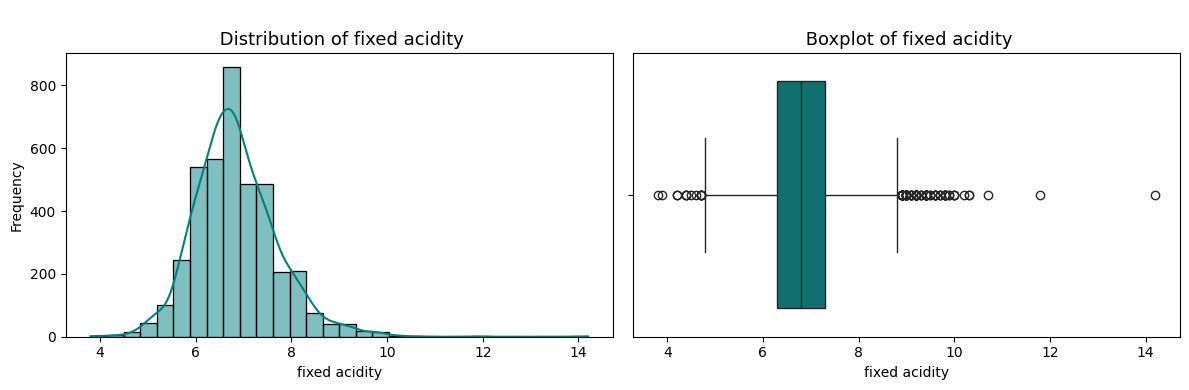

fixed acidity is moderately skewed.


In [12]:
univariate_numerical_eda(rm_df, 'fixed acidity')

 Feature: volatile acidity
       volatile acidity
count       3961.000000
mean           0.280538
std            0.103437
min            0.080000
25%            0.210000
50%            0.260000
75%            0.330000
max            1.100000

Skewness: 1.641
Kurtosis: 5.328


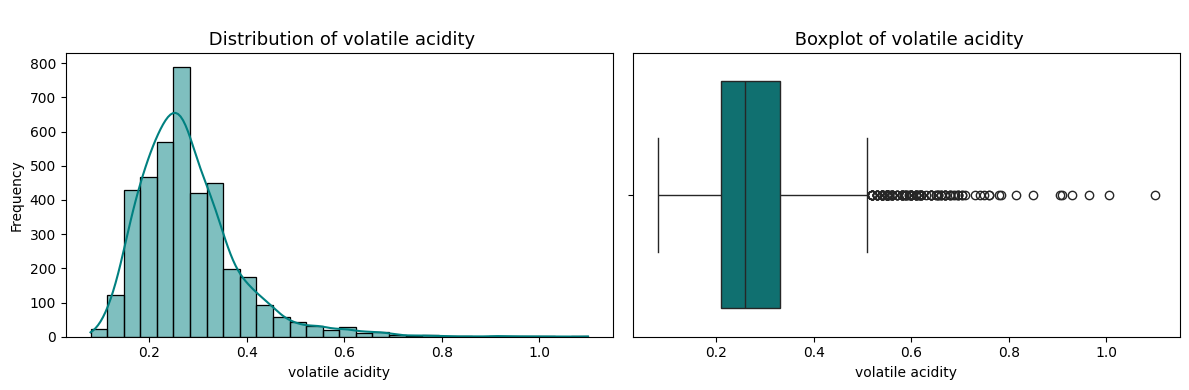


 volatile acidity is highly skewed. Consider log or Box-Cox transformation.


In [13]:
univariate_numerical_eda(rm_df, 'volatile acidity')
# rm_df.head()

 Feature: citric acid
       citric acid
count  3961.000000
mean      0.334332
std       0.122446
min       0.000000
25%       0.270000
50%       0.320000
75%       0.390000
max       1.660000

Skewness: 1.311
Kurtosis: 6.845


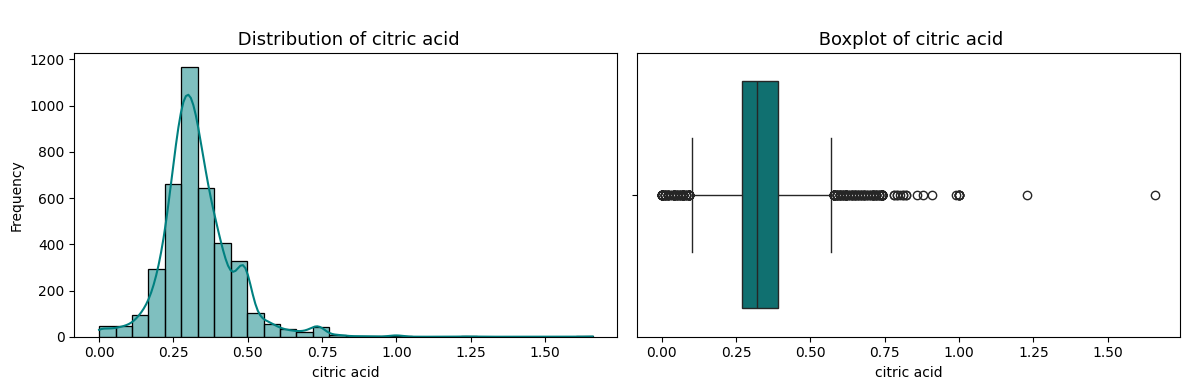


 citric acid is highly skewed. Consider log or Box-Cox transformation.


In [14]:
univariate_numerical_eda(rm_df, 'citric acid')

 Feature: residual sugar
       residual sugar
count     3961.000000
mean         5.914819
std          4.861646
min          0.600000
25%          1.600000
50%          4.700000
75%          8.900000
max         65.800000

Skewness: 1.334
Kurtosis: 5.682


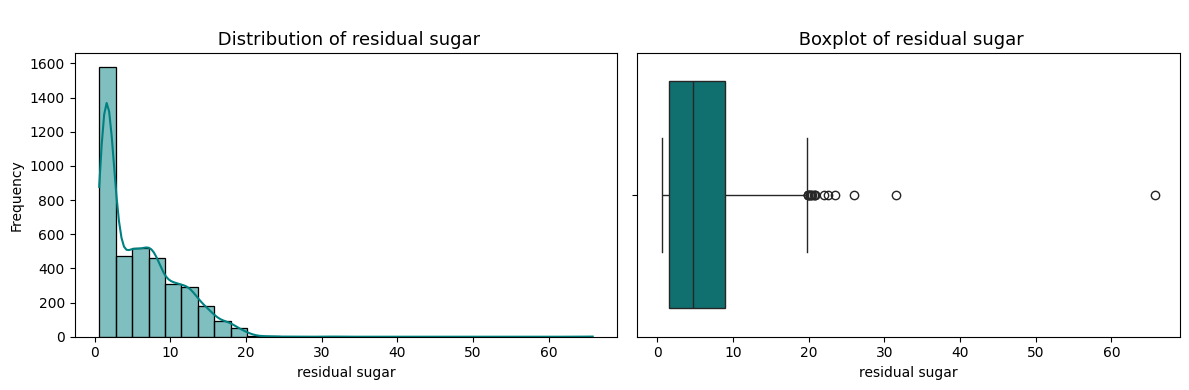


 residual sugar is highly skewed. Consider log or Box-Cox transformation.


In [15]:
univariate_numerical_eda(rm_df, 'residual sugar')

 Feature: chlorides
         chlorides
count  3961.000000
mean      0.045905
std       0.023103
min       0.009000
25%       0.035000
50%       0.042000
75%       0.050000
max       0.346000

Skewness: 4.969
Kurtosis: 35.530


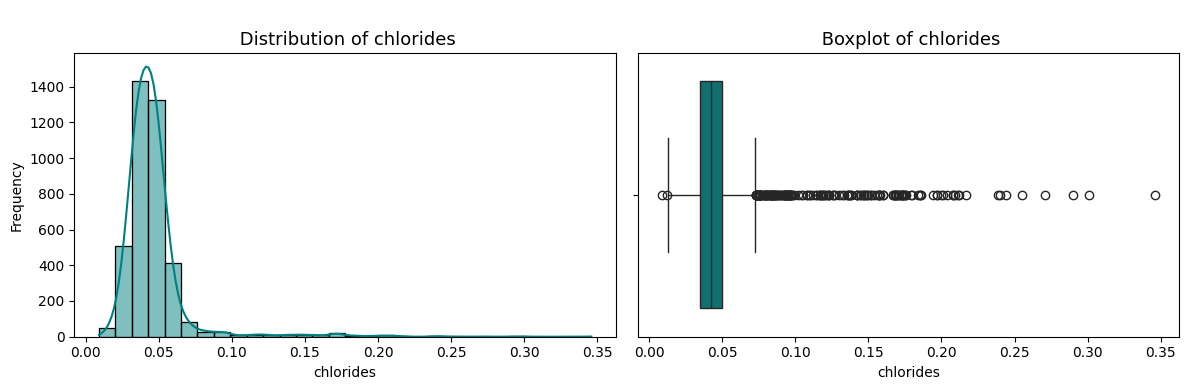


 chlorides is highly skewed. Consider log or Box-Cox transformation.


In [16]:
univariate_numerical_eda(rm_df, 'chlorides')

 Feature: free sulfur dioxide
       free sulfur dioxide
count          3961.000000
mean             34.889169
std              17.210021
min               2.000000
25%              23.000000
50%              33.000000
75%              45.000000
max             289.000000

Skewness: 1.567
Kurtosis: 13.434


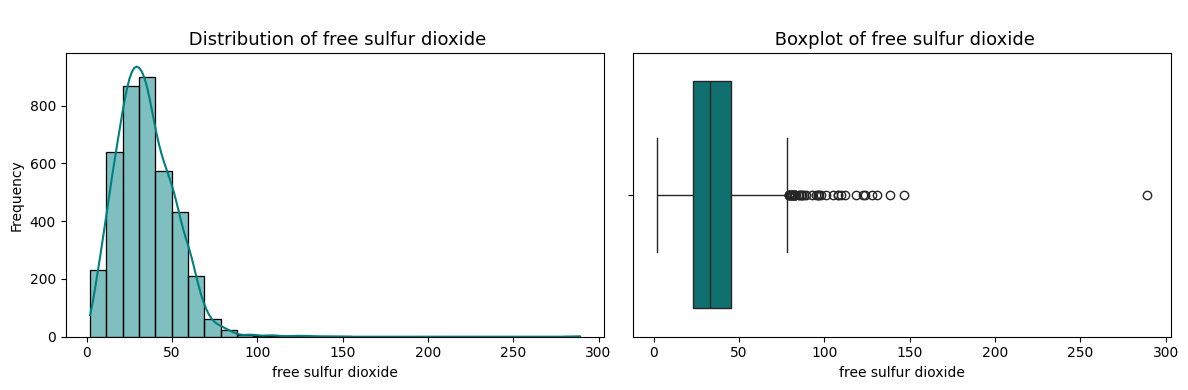


 free sulfur dioxide is highly skewed. Consider log or Box-Cox transformation.


In [17]:
univariate_numerical_eda(rm_df, 'free sulfur dioxide')

 Feature: total sulfur dioxide
       total sulfur dioxide
count           3961.000000
mean             137.193512
std               43.129065
min                9.000000
25%              106.000000
50%              133.000000
75%              166.000000
max              440.000000

Skewness: 0.457
Kurtosis: 0.735


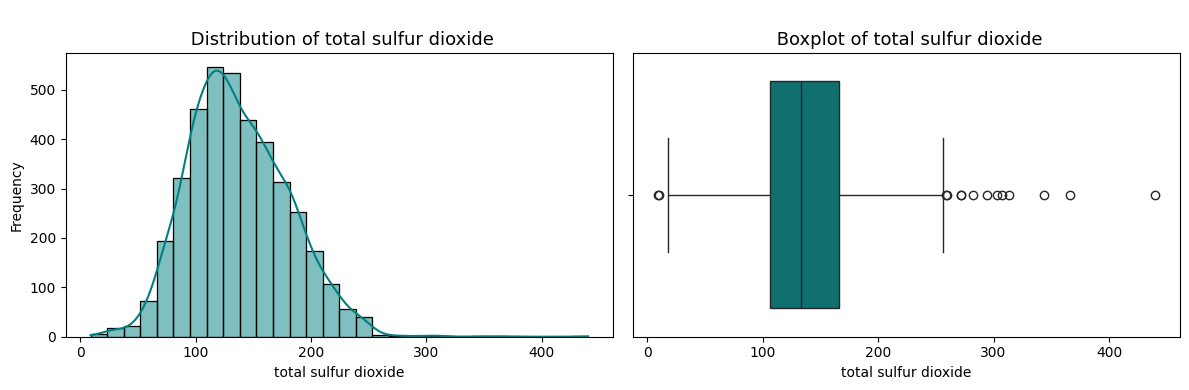

total sulfur dioxide is fairly symmetric.


In [18]:
univariate_numerical_eda(rm_df, 'total sulfur dioxide')

 Feature: density
           density
count  3961.000000
mean      0.993790
std       0.002905
min       0.987110
25%       0.991620
50%       0.993500
75%       0.995710
max       1.038980

Skewness: 1.273
Kurtosis: 14.185


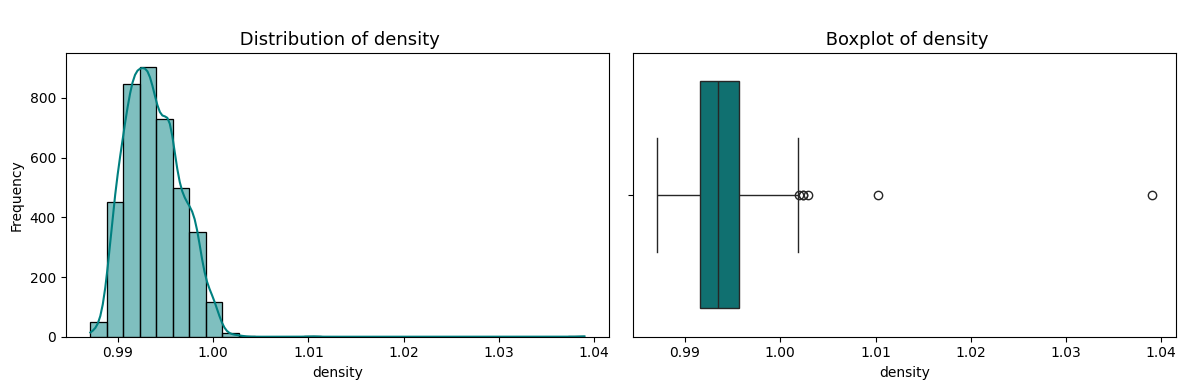


 density is highly skewed. Consider log or Box-Cox transformation.


In [19]:
univariate_numerical_eda(rm_df, 'density')

 Feature: pH
                pH
count  3961.000000
mean      3.195458
std       0.151546
min       2.720000
25%       3.090000
50%       3.180000
75%       3.290000
max       3.820000

Skewness: 0.455
Kurtosis: 0.550


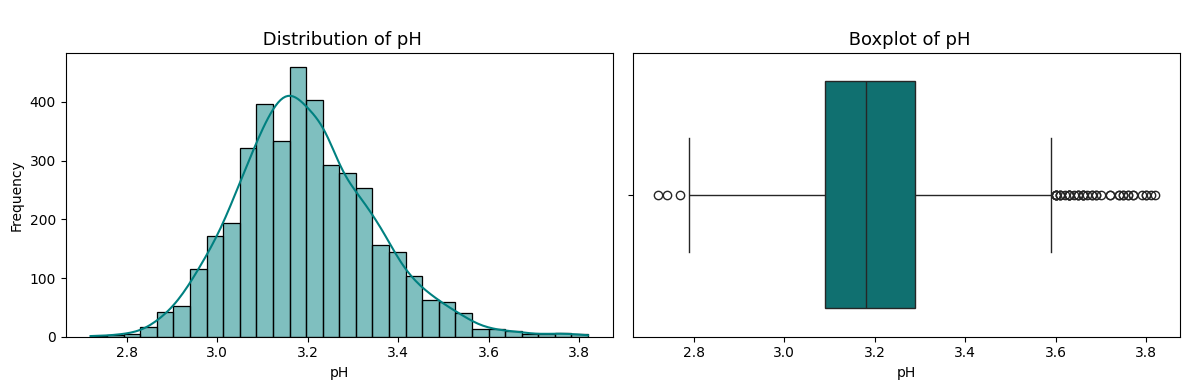

pH is fairly symmetric.


In [20]:
univariate_numerical_eda(rm_df, 'pH')

 Feature: sulphates
         sulphates
count  3961.000000
mean      0.490351
std       0.113523
min       0.220000
25%       0.410000
50%       0.480000
75%       0.550000
max       1.080000

Skewness: 0.938
Kurtosis: 1.565


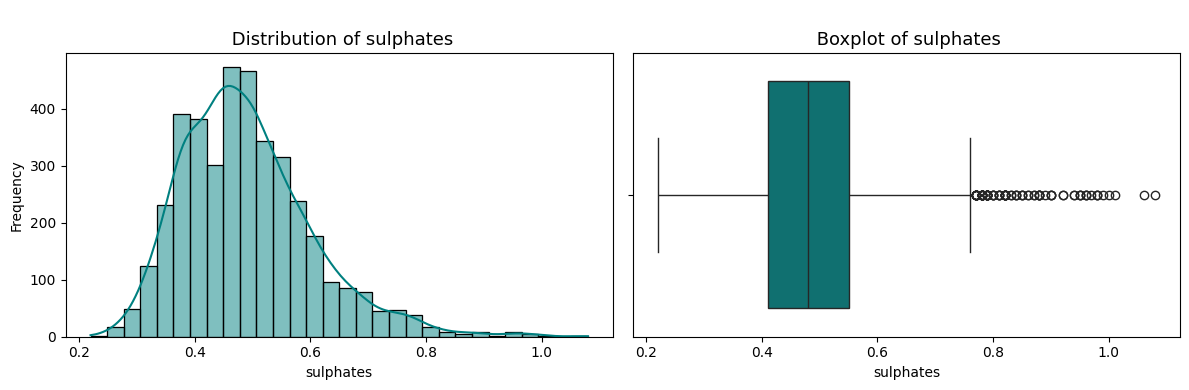

sulphates is moderately skewed.


In [21]:
univariate_numerical_eda(rm_df, 'sulphates')

 Feature: sulphates
         sulphates
count  3961.000000
mean      0.490351
std       0.113523
min       0.220000
25%       0.410000
50%       0.480000
75%       0.550000
max       1.080000

Skewness: 0.938
Kurtosis: 1.565


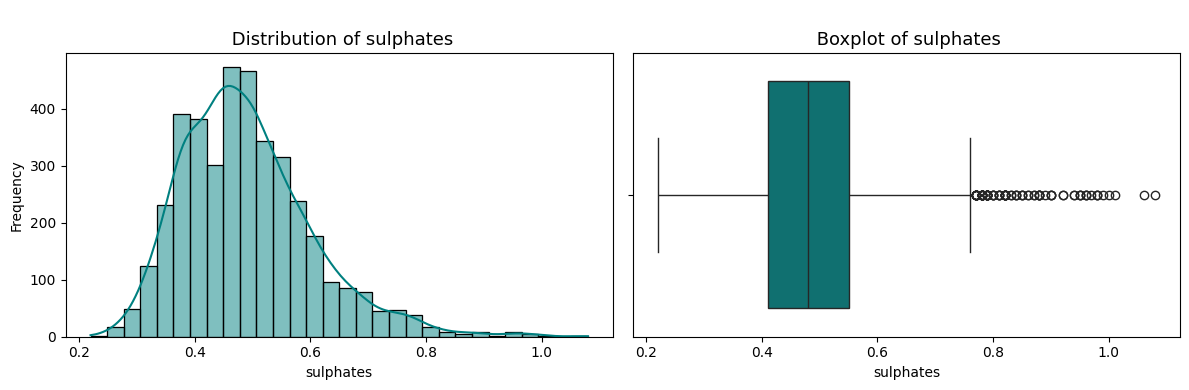

sulphates is moderately skewed.


In [53]:
univariate_numerical_eda(rm_df, 'sulphates')

 Feature: alcohol
           alcohol
count  3961.000000
mean     10.589358
std       1.217076
min       8.000000
25%       9.500000
50%      10.400000
75%      11.400000
max      14.200000

Skewness: 0.451
Kurtosis: -0.696


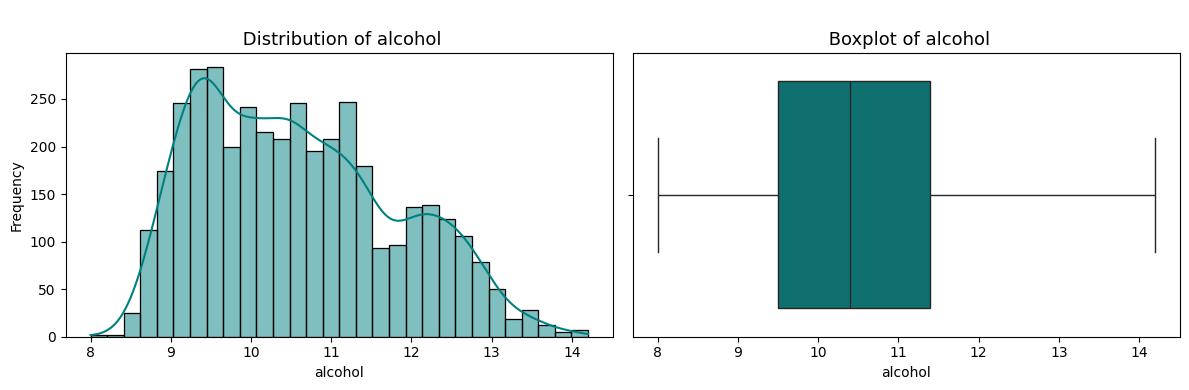

alcohol is fairly symmetric.


In [52]:
univariate_numerical_eda(rm_df, 'alcohol')

 Feature: quality
           quality
count  3961.000000
mean      5.854835
std       0.890683
min       3.000000
25%       5.000000
50%       6.000000
75%       6.000000
max       9.000000

Skewness: 0.112
Kurtosis: 0.299


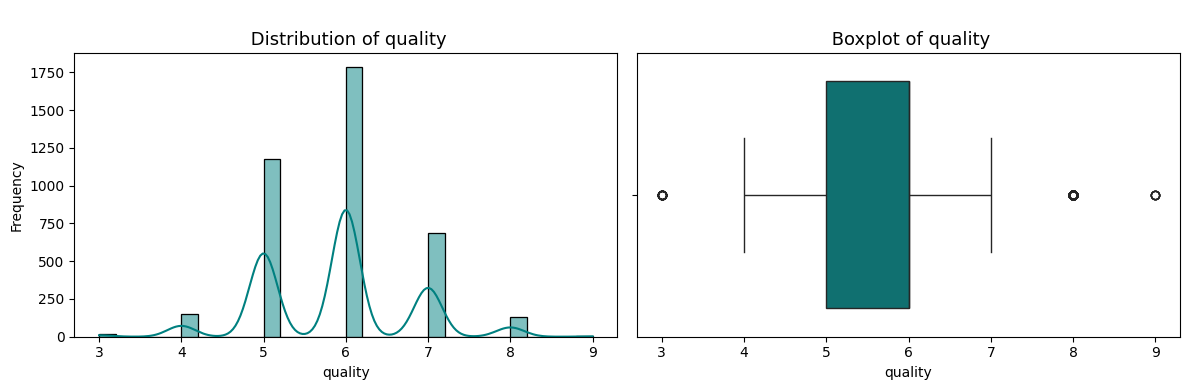

quality is fairly symmetric.


In [64]:
univariate_numerical_eda(rm_df, 'quality')

In [22]:
def correlation_with_target(df, target_col, figsize=(10,2)):
    """
    Plots a heatmap showing correlation of each numeric feature against target_col.
    Returns a Series of correlations (sorted by absolute magnitude).
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include='number').copy()
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric and present in the dataframe.")

    # compute correlations of every numeric column with the target
    corrs = numeric_df.corrwith(numeric_df[target_col]).drop(target_col)

    corrs_df = corrs.to_frame(name='corr').T  # shape (1, n)

    plt.figure(figsize=figsize)
    sns.heatmap(
        corrs_df,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={'orientation': 'vertical', 'shrink':0.7}
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks([0], [target_col], rotation=0)
    plt.title(f'Correlation of each features with {target_col}', fontsize=12)
    plt.tight_layout()
    plt.show()

    # return sorted correlations for downstream use
    return corrs.reindex(corrs.abs().sort_values(ascending=False).index)

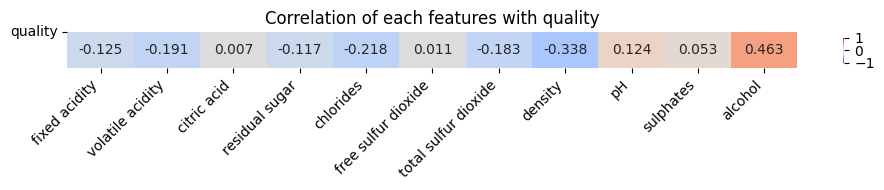

alcohol                 0.462869
density                -0.337805
chlorides              -0.217739
volatile acidity       -0.190678
total sulfur dioxide   -0.183356
fixed acidity          -0.124636
pH                      0.123829
residual sugar         -0.117339
sulphates               0.053200
free sulfur dioxide     0.010507
citric acid             0.007065
dtype: float64

In [67]:
correlation_with_target(rm_df, 'quality')

### Map the quality column into categorical classes as follows:

In [23]:
# classifying the wine quality from Best to Bad in range ([6, 5, 7, 8, 4, 3, 9])
rm_df.loc[:, 'quality'] = rm_df['quality'].replace({9:"Best", 8:"Best", 7:"Good", 6:"Good", 5:"Average", 4:"Bad", 3:"Bad"})

rm_df.head(6)

/var/folders/zt/8_dmsfz96kj95p979jph7bg40000gn/T/ipykernel_7082/1441555003.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Good' 'Good' 'Good' ... 'Good' 'Good' 'Good']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rm_df.loc[:, 'quality'] = rm_df['quality'].replace({9:"Best", 8:"Best", 7:"Good", 6:"Good", 5:"Average", 4:"Bad", 3:"Bad"})


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,Good
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,Good
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,Good
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Good
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,Good
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,Good


### Split the dataset into features X and target y.

In [24]:
X= rm_df.drop(columns="quality") #features
y=rm_df["quality"] #target

### Apply appropriate scaling (StandardScaler or MinMaxScaler) to all numerical features.

In [25]:
scale= MinMaxScaler(feature_range=(0,1))
X_scaled=scale.fit_transform(X)

## 3. Build a Base Classification Model

### Split the data into training and testing sets (e.g., 80/20).

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,random_state=234,stratify=y,test_size=0.2)

### Train a simple model such as Logistic Regression or Decision Tree Classifier.

In [27]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=234, max_iter=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Average       0.52      0.46      0.49       235
         Bad       0.00      0.00      0.00        35
        Best       0.00      0.00      0.00        27
        Good       0.71      0.84      0.77       496

    accuracy                           0.66       793
   macro avg       0.31      0.32      0.31       793
weighted avg       0.60      0.66      0.63       793



/Users/seyistry/Documents/venus/ai_engineering_exam_03_oluwaseyi_egunjobi/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/seyistry/Documents/venus/ai_engineering_exam_03_oluwaseyi_egunjobi/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_re

### Evaluate the model using Accuracy, Precision, Recall, F1-score, and a Confusion Matrix.

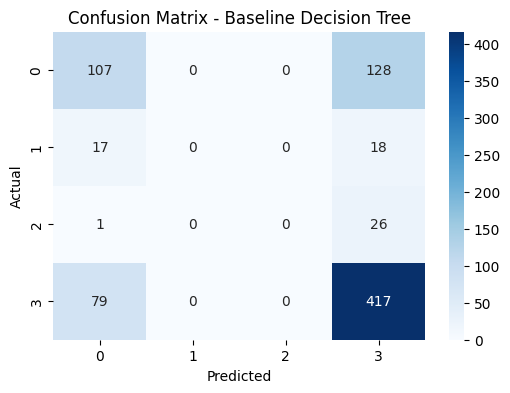

In [28]:
# Confusion Matrix 
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Baseline Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Provide a short interpretation of what the metrics mean in relation to the model’s predictive ability.

### Interpretation of model evaluation metrics

- Accuracy: Overall fraction of correct predictions. Useful as a quick summary, but can be misleading for imbalanced classes — it does not distinguish type of error.
- Precision: Of the instances predicted as a given class, precision is the fraction that truly belong to that class. High precision means the model makes few false-positive errors for that class.
- Recall (Sensitivity): Of the true instances of a class, recall is the fraction the model correctly identified. High recall means the model misses few true positives (few false negatives).
- F1-score: The harmonic mean of precision and recall. Preferable when we want a single metric balancing false positives and false negatives, especially for imbalanced classes.
- Confusion Matrix: Shows per-class counts of true positives, false positives, false negatives, and true negatives. Use it to identify which classes the model confuses (e.g., 
 vs 
).

In this multi-class wine-quality task, rely on per-class precision/recall and macro-averaged F1 to judge balanced performance across 'Best', 'Good', 'Average', and 'Bad' classes. A high overall accuracy with low per-class recall for minority classes indicates the model favors majority classes; the confusion matrix will reveal such behavior.

## 4. Build and Compare Multiple Models

### Train at least three different classification models (e.g., Random Forest, K-Nearest Neighbors, Gradient Boosting, Support Vector Machine).

In [29]:
# let put all our model together for easy looping
models={
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree':DecisionTreeClassifier(),
    'K nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(),
    'Naive Bayes': GaussianNB()
}

### Evaluate each model using the same set of metrics: Accuracy, Precision, Recall, F1-score, and Confusion Matrix.

Logistic Regression is in training section...
Logistic Regression Accuracy:0.68


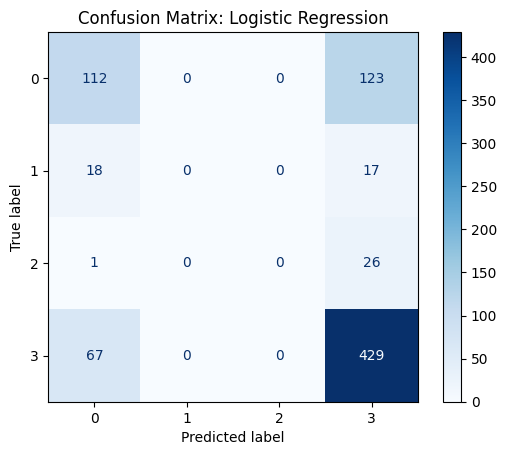

Random Forest is in training section...
Random Forest Accuracy:0.69


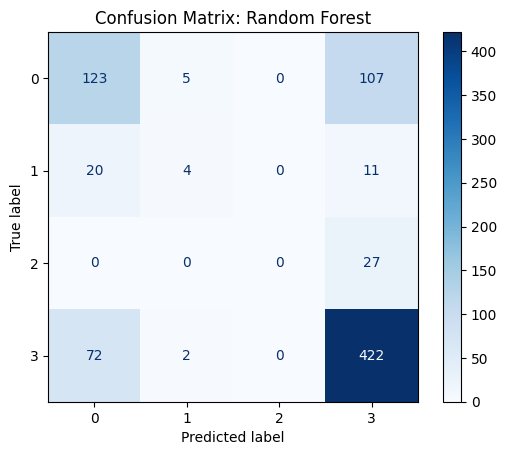

Decision Tree is in training section...
Decision Tree Accuracy:0.60


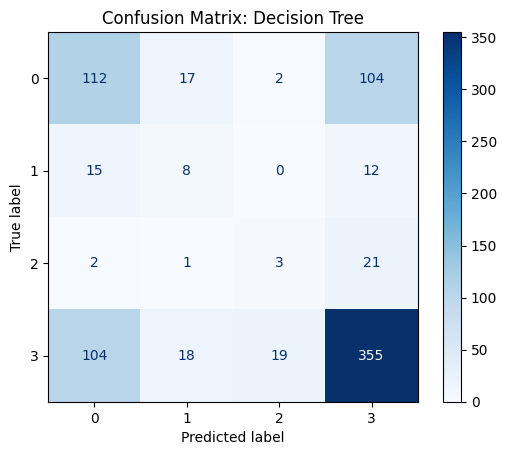

K nearest Neighbors is in training section...
K nearest Neighbors Accuracy:0.67


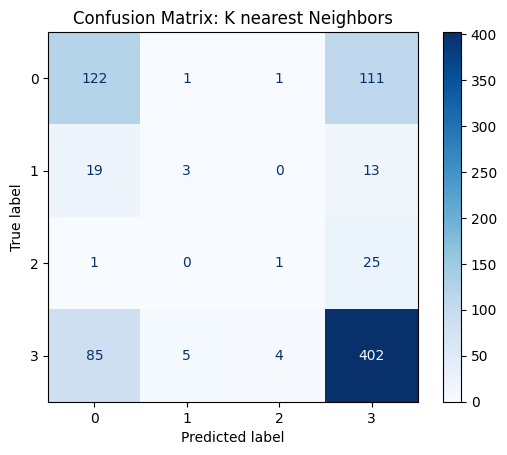

SVM is in training section...
SVM Accuracy:0.69


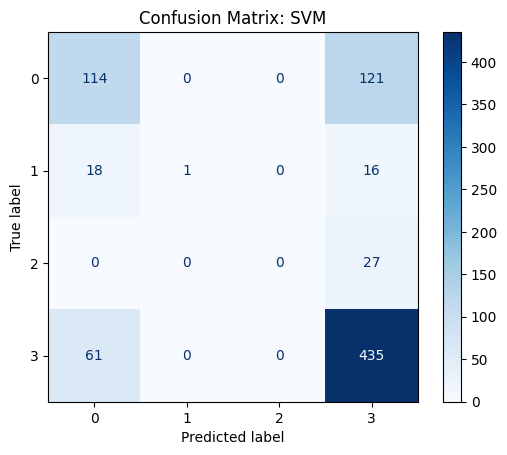

Naive Bayes is in training section...
Naive Bayes Accuracy:0.64


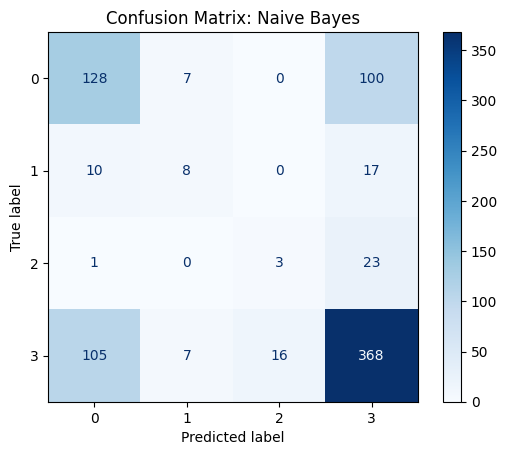

,Model,Accuracy
0,SVM,0.693569
1,Random Forest,0.692308
2,Logistic Regression,0.682219
3,K nearest Neighbors,0.665826
4,Naive Bayes,0.639344
5,Decision Tree,0.602774


In [30]:
# initialize a dictionary to store the models results
results={}
for model_name, model in models.items():
    print(f"{model_name} is in training section...")
    model.fit(X_train,y_train)
    y_pred= model.predict(X_test)
    accuracy= accuracy_score(y_test,y_pred)
    results[model_name]=accuracy
    print(f'{model_name} Accuracy:{accuracy:.2f}')

    # let add confusion matrix
    cm= confusion_matrix(y_test,y_pred)
    display= ConfusionMatrixDisplay(cm)

    # plot for visual and make the model name title
    display.plot(cmap="Blues")
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

# Let print the results in a dataframe for better visualization
results_df= pd.DataFrame(results.items(), columns=['Model', 'Accuracy'])
results_df= results_df.sort_values(by='Accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

### Identify and justify which model performs best based on a balance of these metrics.

Random Forest performed best, it has the highest number of accuracy and also the lowers number of Type 2 + Type1 errors

## 5. Optimize Model Using Randomized Search

### Use RandomizedSearchCV to perform hyperparameter optimization on the best model.

In [31]:
# let turn Random Forest
rf= RandomForestClassifier()
# display default parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Retrain the model using the optimal parameters found.

In [32]:
# let's create a parameter grid for RandomizedSearchCV
param_grid={
    'n_estimators':[50,100,200],
    'max_depth':[10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
}

# let define RandomsearchCV (we use randomsearch to reduce computational cost)
rf_random= RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=5, verbose=2, random_state=234, n_jobs=-1)
rf_random.fit(X_train,y_train)
# Print best parameters from random search
print(f"Best Parameters from Randomized Search: {rf_random.best_params_}")

# let do cross validation for the best estimator
best_rf= rf_random.best_estimator_
cv_scores= cross_val_score(best_rf,X_train,y_train, cv=5)
print(f"Cross-validation scores for Random Forest: {cv_scores}")
print(f"Mean Cross-validation score: {np.mean(cv_scores):.2f}")




Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=20, min_samples_

### Re-evaluate the model using the same classification metrics.

In [33]:
# let use the best model to predict on test set
y_pred_best= best_rf.predict(X_test)
# Display classification report
print("Classification Report for Best Random Forest Model:")
print(classification_report(y_test,y_pred_best))

Classification Report for Best Random Forest Model:
              precision    recall  f1-score   support

     Average       0.56      0.49      0.52       235
         Bad       0.58      0.20      0.30        35
        Best       1.00      0.04      0.07        27
        Good       0.73      0.85      0.79       496

    accuracy                           0.68       793
   macro avg       0.72      0.39      0.42       793
weighted avg       0.68      0.68      0.66       793



### Provide a short commentary on whether optimization improved model performance and why.

#### Provide a short commentary on whether optimization improved model performance and why.

- After RandomizedSearchCV, we evaluated the best estimator (`best_rf`) on the test set and compared the classification report to the baseline Random Forest performance. Improvements are typically visible as increases in accuracy and in per-class precision/recall/F1 scores, especially for classes that were previously under-predicted.
- Randomized search explores more diverse hyperparameter combinations (n_estimators, max_depth, min_samples_split, min_samples_leaf). Improvements usually come from: better tree depth (reducing under/overfitting), an increased number of estimators (reducing variance), and sensible leaf/split constraints (improving generalization).
- If the `best_rf` shows modest or no improvement, likely reasons include: the original model was already near optimal for this dataset, the hyperparameter ranges were not wide enough, or the dataset size limits further gains. Cross-validation scores printed earlier provide a more robust view of generalization than a single test-set score.

Conclusion: Use the cross-validation mean and the test-set classification report together — if both improved, optimization helped. If only CV improved slightly but test metrics did not, consider expanding search ranges, using more iterations, or performing nested CV.

## 6. Save Model and Scaler

In [35]:
## Saving the data
joblib.dump(best_rf, 'model.pkl')

# let save the scaler too
joblib.dump(scale, 'scaler.pkl')
print("=="*40)
print("Best Random Forest model and scaler have been saved successfully.")
print("=="*40)

Best Random Forest model and scaler have been saved successfully.


## 7. Build an API Endpoint for Prediction

### Check main.py for task Ex. 7

## 8. Model Interpretation and Business Impact Report

### Check report.txt